In [3]:
# !wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

# General Imports and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import UnitaryOverlap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# from qiskit_serverless import IBMServerlessClient, QiskitFunction
from qiskit_ibm_catalog import QiskitServerless, QiskitFunction


def visualize_counts(res_counts, num_qubits, num_shots):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = res_counts.get(0, 0.0)
    top_10 = dict(
        sorted(res_counts.items(), key=lambda item: item[1], reverse=True)[
            :10
        ]
    )
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    x_vals, y_vals = list(zip(*by_key.items()))
    x_vals = [bin(x_val)[2:].zfill(num_qubits) for x_val in x_vals]
    y_vals_prob = []
    for t in range(len(y_vals)):
        y_vals_prob.append(y_vals[t] / num_shots)
    y_vals = y_vals_prob
    plt.bar(x_vals, y_vals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Probability")
    plt.show()


def get_training_data():
    """Read the training data."""
    df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
    training_data = df.values[:20, :]
    ind = np.argsort(training_data[:, -1])
    X_train = training_data[ind][:, :-1]

    return X_train

/var/folders/g8/dr30p5895453c423rt8nqf0r0000gn/T/ipykernel_4307/2017045485.py:29: DeprecationWarning: The class ``qiskit.circuit.library.overlap.UnitaryOverlap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.unitary_overlap instead.
  overlap_circ = UnitaryOverlap(unitary1, unitary2)


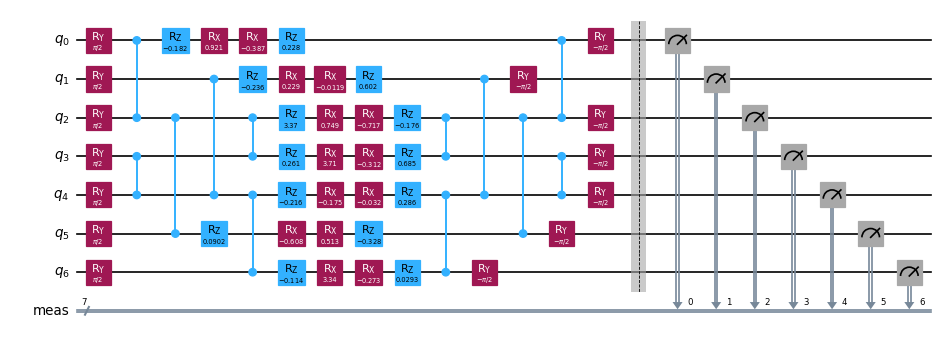

In [4]:
# Prepare training data
X_train = get_training_data()

# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

# Assign tunable parameter to known optimal value and set the data params for first two samples
x1 = 14
x2 = 19
unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

# Create the overlap circuit
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()
overlap_circ.draw("mpl", scale=0.6, style="iqp")

qiskit_runtime_service._discover_account:WARNING:2025-12-12 10:30:32,960: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-12-12 10:30:36,317: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-12 10:30:36,931: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-12 10:30:39,588: Using instance: open-instance, plan: open


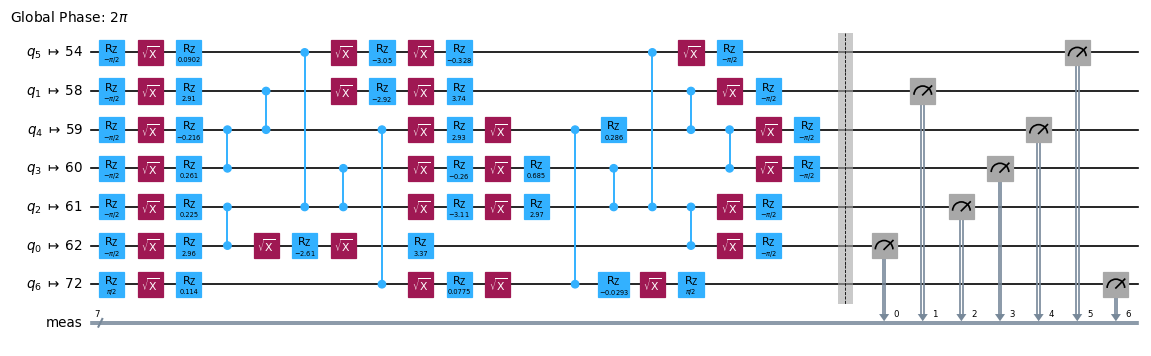

In [ ]:
#from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(token="<your token here>")#, instance="ibm_fez")

#service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=overlap_circ.num_qubits
)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)
overlap_ibm.draw("mpl", scale=0.6, idle_wires=False, fold=-1, style="iqp")

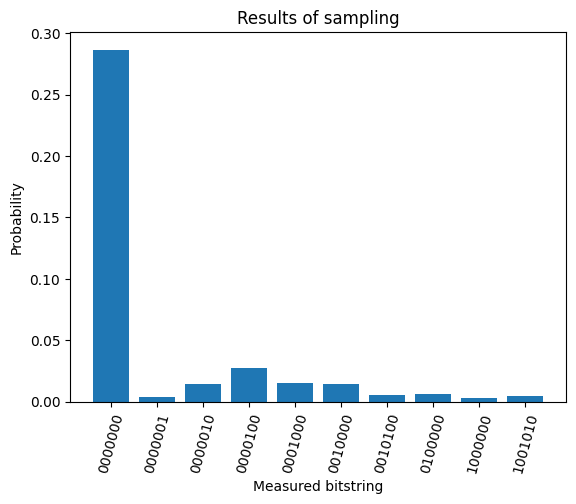

In [9]:
num_shots = 10_000

## Evaluate the problem using statevector-based primitives from Qiskit
# from qiskit.primitives import StatevectorSampler

# sampler = StatevectorSampler()
# results = sampler.run([overlap_circ]).result()
# counts = results[0].data.meas.get_int_counts()

# Evaluate the problem using a QPU via Qiskit IBM Runtime

sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm]).result()
counts = results[0].data.meas.get_int_counts()

visualize_counts(counts, num_qubits, num_shots)

In [10]:
# Calculate the fidelity, or the probability to measure 0
kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
print(f"Fidelity: {kernel_matrix[x1, x2]}")

Fidelity: 0.2866


In [12]:
# serverless = QiskitServerless()

# kernel_entry_pattern = QiskitFunction(
#     title="generate-kernel-entry",
#     entrypoint="generate_kernel_entry.py",
#     working_dir="./source/",
# )

# serverless.upload(kernel_entry_pattern)

In [ ]:
generate_kernel_entry = serverless.load("generate-kernel-entry")
job = generate_kernel_entry.run(
    sample1=list(X_train[x1]), sample2=list(X_train[x2])
)

kernel_matrix[x1, x2] = job.result()["fidelity"]
print(f"fidelity: {kernel_matrix[x1, x2]}")

© IBM Corp., 2017-2025